# Intro...

In [178]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests

## Data Acquisition

In [155]:
#Define headers
headers = {
    'User-Agent': 'https://github.com/kentdanas',
    'From': 'kdanas@uw.edu'
}

#Create dictionary to save dataframes
views = {}

In [156]:
#Function to save data from API calls
def api_call(endpoint,params):
    call = requests.get(endpoint.format(**params), headers=headers)
    response = call.json()
    return response

### Pagecount (Legacy Data)

In [228]:
#Define endpoint
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

#Define access points
access_sites = ['mobile-site', 'desktop-site']

#Make API call for each access point
for access_site in access_sites:
    
    #Define filename and parameters to pass to API call
    file_name = '../data_raw/pagecounts_' + access_site + '_200801_201809.json'

    params_legacy = {"project" : "en.wikipedia.org",
                     "access-site" : access_site,
                     "granularity" : "monthly",
                     "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                     "end" : "2016070100"
                    }
    
    #Make API call
    monthly_pagecounts = api_call(endpoint_legacy, params_legacy)
    
    #Save raw data file
    with open(file_name, 'w') as f:
        json.dump(monthly_pagecounts, f)
        
    #Also save data to dataframe in pagecount dictionary
    df = pd.DataFrame(monthly_pagecounts['items'])
    view_name = 'pagecount_' + access_site + '_views'
    df.rename(columns={'count': view_name}, inplace=True)
    views[view_name] = df

### Pageview (New Data)

In [229]:
#Define endpoint
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

#Define access points
access_sites = ['mobile-app', 'desktop', 'mobile-web']

#Make API call for each access point
for access_site in access_sites:
    
    #Define filename and parameters to pass to API call
    file_name = '../data_raw/pageviews_' + access_site + '_201507_201809.json'
    
    params_pageviews = {"project" : "en.wikipedia.org",
                        "access" : access_site,
                        "agent" : "user",
                        "granularity" : "monthly",
                        "start" : "2001010100",
                        # for end use 1st day of month following final month of data
                        "end" : '2018101000'
                        }
    
    #Make API call
    monthly_pageviews = api_call(endpoint_pageviews, params_pageviews)
    
    #Save raw data file
    with open(file_name, 'w') as f:
        json.dump(monthly_pageviews, f)
    
    #Also save data to dataframe in pageview dictionary
    df = pd.DataFrame(monthly_pageviews['items'])
    view_name = 'pageview_' + access_site + '_views'
    df.rename(columns={'views': view_name}, inplace=True)
    views[view_name] = df

## Data Processing

In [230]:
#Merge all dataframes from both data dictionaries
keys = list(views.keys())
combined_data = views[keys[0]]

for i in range(1, len(keys)):
    combined_data = combined_data.merge(views[keys[i]], how = 'outer', on = ['timestamp'])


In [231]:
#Create additional needed columns
combined_data['year'] = combined_data['timestamp'].str[0:4]
combined_data['month'] = combined_data['timestamp'].str[4:6]
combined_data['pageview_mobile_views'] = combined_data['pageview_mobile-app_views'] + combined_data['pageview_mobile-web_views']
combined_data['pagecount_all_views'] = combined_data['pagecount_mobile-site_views'] + combined_data['pagecount_desktop-site_views']
combined_data['pageview_all_views'] = combined_data['pageview_mobile_views'] + combined_data['pageview_desktop_views']

In [232]:
#Keep only needed columns
combined_data = combined_data[['year',
                              'month',
                              'pagecount_all_views',
                              'pagecount_desktop-site_views', 
                              'pagecount_mobile-site_views',
                              'pageview_all_views',
                              'pageview_mobile_views', 
                              'pageview_desktop_views']]

#Rename columns
combined_data.rename(columns={'pagecount_mobile-site_views':'pagecount_mobile_views'}, inplace=True)
combined_data.rename(columns={'pagecount_desktop-site_views':'pagecount_desktop_views'}, inplace=True)

In [233]:
#Fill zeros
combined_data = combined_data.fillna(0)

#Sort
combined_data = combined_data.sort_values(['year', 'month'])

In [234]:
#Save CSV
combined_data.to_csv('../data_clean/en-wikipedia_traffic_200801-201709.csv', index = False)

## Analysis

In [222]:
combined_data

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_mobile_views,pageview_desktop_views
21,2007,12,nan,2.99833e+09,nan,nan,nan,nan
22,2008,01,nan,4.9309e+09,nan,nan,nan,nan
23,2008,02,nan,4.81839e+09,nan,nan,nan,nan
24,2008,03,nan,4.95541e+09,nan,nan,nan,nan
25,2008,04,nan,5.15916e+09,nan,nan,nan,nan
26,2008,05,nan,5.58469e+09,nan,nan,nan,nan
27,2008,06,nan,5.7121e+09,nan,nan,nan,nan
28,2008,07,nan,5.3063e+09,nan,nan,nan,nan
29,2008,08,nan,5.14016e+09,nan,nan,nan,nan
30,2008,09,nan,5.47953e+09,nan,nan,nan,nan


In [235]:
dates = pd.to_datetime(combined_data['year'] + combined_data['month'], format='%Y%m')
combined_data.replace(0, float('nan'), inplace=True)

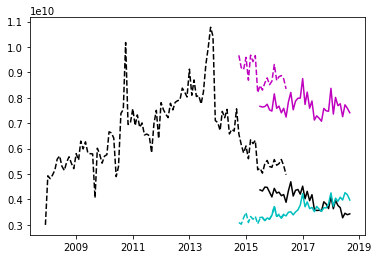

In [242]:
plt.plot(dates, combined_data['pagecount_desktop_views'], 'k--')
plt.plot(dates, combined_data['pagecount_mobile_views'], 'c--')
plt.plot(dates, combined_data['pagecount_all_views'], 'm--')
plt.plot(dates, combined_data['pageview_desktop_views'], 'k-')
plt.plot(dates, combined_data['pageview_mobile_views'], 'c-')
plt.plot(dates, combined_data['pageview_all_views'], 'm-')